In [3]:
# derived from:
# https://github.com/higgsfield/RL-Adventure-2/blob/master/7.soft%20actor-critic.ipynb
# found link at https://towardsdatascience.com/soft-actor-critic-demystified-b8427df61665
# altered to run biped

import math
import random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal

In [4]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

<h2>Use CUDA</h2>

In [5]:
use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")

<h2>Replay Buffer</h2>

In [6]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0
    
    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done
    
    def __len__(self):
        return len(self.buffer)

In [7]:
# class NormalizedActions(gym.ActionWrapper):
#     def _action(self, action):
#         low  = self.action_space.low
#         high = self.action_space.high
        
#         action = low + (action + 1.0) * 0.5 * (high - low)
#         action = np.clip(action, low, high)
        
#         return action

#     def _reverse_action(self, action):
#         low  = self.action_space.low
#         high = self.action_space.high
        
#         action = 2 * (action - low) / (high - low) - 1
#         action = np.clip(action, low, high)
        
#         return actions

<h1>Soft Actor-Critic: Off-Policy Maximum Entropy Deep Reinforcement Learning with a Stochastic Actor</h1>
<h2><a href="https://arxiv.org/abs/1801.01290">Arxiv</a></h2>

In [20]:
class ValueNetwork(nn.Module):
    def __init__(self, state_dim, hidden_dim, init_w=3e-3):
        super(ValueNetwork, self).__init__()
        
        self.linear1 = nn.Linear(state_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear2_2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, 1)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear2_2(x))
        x = self.linear3(x)
        return x
        
        
class SoftQNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-3):
        super(SoftQNetwork, self).__init__()
        
        self.linear1 = nn.Linear(num_inputs + num_actions, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear2_2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, 1)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear2_2(x))
        x = self.linear3(x)
        return x
        
        
class PolicyNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-3, log_std_min=-20, log_std_max=2):
        super(PolicyNetwork, self).__init__()
        
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max
        
        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear2_2 = nn.Linear(hidden_size, hidden_size)
        
        self.mean_linear = nn.Linear(hidden_size, num_actions)
        self.mean_linear.weight.data.uniform_(-init_w, init_w)
        self.mean_linear.bias.data.uniform_(-init_w, init_w)
        
        self.log_std_linear = nn.Linear(hidden_size, num_actions)
        self.log_std_linear.weight.data.uniform_(-init_w, init_w)
        self.log_std_linear.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear2_2(x))
        
        mean    = self.mean_linear(x)
        log_std = self.log_std_linear(x)
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)
        
        return mean, log_std
    
    def evaluate(self, state, epsilon=1e-6):
        mean, log_std = self.forward(state)
        std = log_std.exp()
        
        normal = Normal(mean, std)
        z = normal.sample()
        action = torch.tanh(z)
        
        log_prob = normal.log_prob(z) - torch.log(1 - action.pow(2) + epsilon)
        log_prob = log_prob.sum(-1, keepdim=True)
        
        return action, log_prob, z, mean, log_std
        
    
    def get_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        mean, log_std = self.forward(state)
        std = log_std.exp()
        
        normal = Normal(mean, std)
        z      = normal.sample()
        action = torch.tanh(z)
        
        action  = action.detach().cpu().numpy()
        return action[0]

In [21]:
def soft_q_update(batch_size, 
           gamma=0.99,
           mean_lambda=1e-3,
           std_lambda=1e-3,
           z_lambda=0.0,
           soft_tau=1e-2,
          ):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    state      = torch.FloatTensor(state).to(device)
    next_state = torch.FloatTensor(next_state).to(device)
    action     = torch.FloatTensor(action).to(device)
    reward     = torch.FloatTensor(reward).unsqueeze(1).to(device)
    done       = torch.FloatTensor(np.float32(done)).unsqueeze(1).to(device)

    expected_q_value = soft_q_net(state, action)
    expected_value   = value_net(state)
    new_action, log_prob, z, mean, log_std = policy_net.evaluate(state)


    target_value = target_value_net(next_state)
    next_q_value = reward + (1 - done) * gamma * target_value
    q_value_loss = soft_q_criterion(expected_q_value, next_q_value.detach())

    expected_new_q_value = soft_q_net(state, new_action)
    next_value = expected_new_q_value - log_prob
    value_loss = value_criterion(expected_value, next_value.detach())

    log_prob_target = expected_new_q_value - expected_value
    policy_loss = (log_prob * (log_prob - log_prob_target).detach()).mean()
    

    mean_loss = mean_lambda * mean.pow(2).mean()
    std_loss  = std_lambda  * log_std.pow(2).mean()
    z_loss    = z_lambda    * z.pow(2).sum(1).mean()

    policy_loss += mean_loss + std_loss + z_loss

    soft_q_optimizer.zero_grad()
    q_value_loss.backward()
    soft_q_optimizer.step()

    value_optimizer.zero_grad()
    value_loss.backward()
    value_optimizer.step()

    policy_optimizer.zero_grad()
    policy_loss.backward()
    policy_optimizer.step()
    
    
    for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
        target_param.data.copy_(
            target_param.data * (1.0 - soft_tau) + param.data * soft_tau
        )

In [22]:
# env = NormalizedActions(gym.make("Pendulum-v0"))
env = gym.make('BipedalWalker-v2')

action_dim = env.action_space.shape[0]
state_dim  = env.observation_space.shape[0]
hidden_dim = 256

value_net        = ValueNetwork(state_dim, hidden_dim).to(device)
target_value_net = ValueNetwork(state_dim, hidden_dim).to(device)

soft_q_net = SoftQNetwork(state_dim, action_dim, hidden_dim).to(device)
policy_net = PolicyNetwork(state_dim, action_dim, hidden_dim).to(device)

for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
    target_param.data.copy_(param.data)
    

value_criterion  = nn.MSELoss()
soft_q_criterion = nn.MSELoss()

value_lr  = 3e-4
soft_q_lr = 3e-4
policy_lr = 3e-4

value_optimizer  = optim.Adam(value_net.parameters(), lr=value_lr)
soft_q_optimizer = optim.Adam(soft_q_net.parameters(), lr=soft_q_lr)
policy_optimizer = optim.Adam(policy_net.parameters(), lr=policy_lr)


replay_buffer_size = 1000000
replay_buffer = ReplayBuffer(replay_buffer_size)

In [23]:
def normalize_action(action, action_space):
        low  = action_space.low
        high = action_space.high
        
        action = low + (action + 1.0) * 0.5 * (high - low)
        action = np.clip(action, low, high)
        return action

In [24]:
def plot(episode, rewards, recent_rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('episode %s. reward: %s' % (episode, rewards[-1]))
    plt.plot(rewards)
    plt.plot(recent_rewards)
    plt.show()

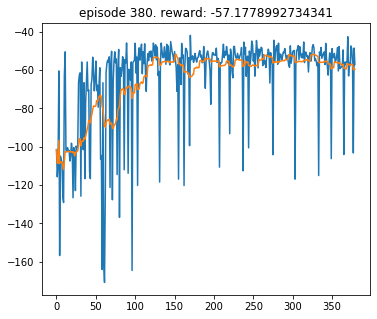

Episode 381	Average Reward: -59.75	Reward: -59.97
Episode 382	Average Reward: -59.78	Reward: -59.38
Episode 383	Average Reward: -59.62	Reward: -55.28
Episode 384	Average Reward: -59.38	Reward: -53.21
Episode 385	Average Reward: -59.46	Reward: -51.21
Episode 386	Average Reward: -56.94	Reward: -53.67
Episode 387	Average Reward: -56.51	Reward: -47.17
Episode 388	Average Reward: -59.42	Reward: -115.37
Episode 389	Average Reward: -59.38	Reward: -54.99
Episode 390	Average Reward: -59.22	Reward: -52.80
Episode 391	Average Reward: -59.70	Reward: -52.28
Episode 392	Average Reward: -59.01	Reward: -49.31
Episode 393	Average Reward: -58.68	Reward: -49.58
Episode 394	Average Reward: -58.28	Reward: -49.91
Episode 395	Average Reward: -58.61	Reward: -54.05
Episode 396	Average Reward: -59.04	Reward: -57.83
Episode 397	Average Reward: -58.76	Reward: -50.12
Episode 398	Average Reward: -56.32	Reward: -54.45
Episode 399	Average Reward: -56.63	Reward: -54.93


In [25]:
num_episodes  = 400
max_steps   = 1000
episode   = 0
rewards     = []
mean_reward = []
batch_size  = 128

for episode in range(1,num_episodes):
    state = env.reset()
    episode_reward = 0
    
    for step in range(max_steps):
        action = policy_net.get_action(state)
        
        next_state, reward, done, _ = env.step(normalize_action(action,env.action_space))
        
        replay_buffer.push(state, action, reward, next_state, done)
        if len(replay_buffer) > batch_size:
            soft_q_update(batch_size)
        
        state = next_state
        episode_reward += reward
        
        if done:
            break
    
    rewards.append(episode_reward)
    recent_rewards.append(episode_reward)
    mean_reward.append(np.mean(rewards[-20:]))

    print('Episode {}\tAverage Reward: {:.2f}\tReward: {:.2f}'.format(episode, mean_reward[-1], episode_reward))
        
    if episode % 20 == 0:
        plot(episode, rewards,mean_reward)

In [26]:
# agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
# agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))
state = env.reset()
while True:
    # action = agent.act(state)
    env.render()
    action = policy_net.get_action(state)
    next_state, reward, done, _ = env.step(normalize_action(action,env.action_space))
    state = next_state
    if done:
        break
        
env.close()

KeyboardInterrupt: 